# K-Means Clustering

Your assignment is to use the TMDB 5000 dataset from Kaggle to try and cluster similar movies. 

It may be helpful to use PCA to reduce the dimensions of your data first - but then again maybe not. I dunno, you're the data scientist, you tell me. 🤪 

I'll let you download the dataset and get it into your notebook in the way that works best for you:

<https://www.kaggle.com/tmdb/tmdb-movie-metadata/version/2>

There are a few weird data cleaning steps that you'll need to do that I don't want you to get stuck on or spend a lot of time on so I'll try and help you out a little bit. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/tmdb_5000_movies.csv")
print(df.shape)
df.head()

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.4376,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.0826,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.3768,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.3130,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.9270,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [0]:
# There's probably some pandas function that will do this but...
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in df.iteritems():
    if type(colvalue[1]) == str:
         str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = df.columns.difference(str_list)  

In [9]:
# Filter the dataframe by only the numeric columns
df_numeric = df[num_list]
df_numeric.head(3)

,budget,id,popularity,revenue,runtime,vote_average,vote_count
0,237000000,19995,150.4376,2787965087,162.0,7.2,11800
1,300000000,285,139.0826,961000000,169.0,6.9,4500
2,245000000,206647,107.3768,880674609,148.0,6.3,4466


In [0]:
# lazily fill NaNs with zeros
X = df_numeric.fillna(value=0, axis=1).drop(columns='id')

In [27]:
print(X.shape)
X.head(3)

(4803, 6)


,budget,popularity,revenue,runtime,vote_average,vote_count
0,237000000,150.4376,2787965087,162.0,7.2,11800
1,300000000,139.0826,961000000,169.0,6.9,4500
2,245000000,107.3768,880674609,148.0,6.3,4466


# You take it from here!

See what you can come up with. You have all the know-how! 

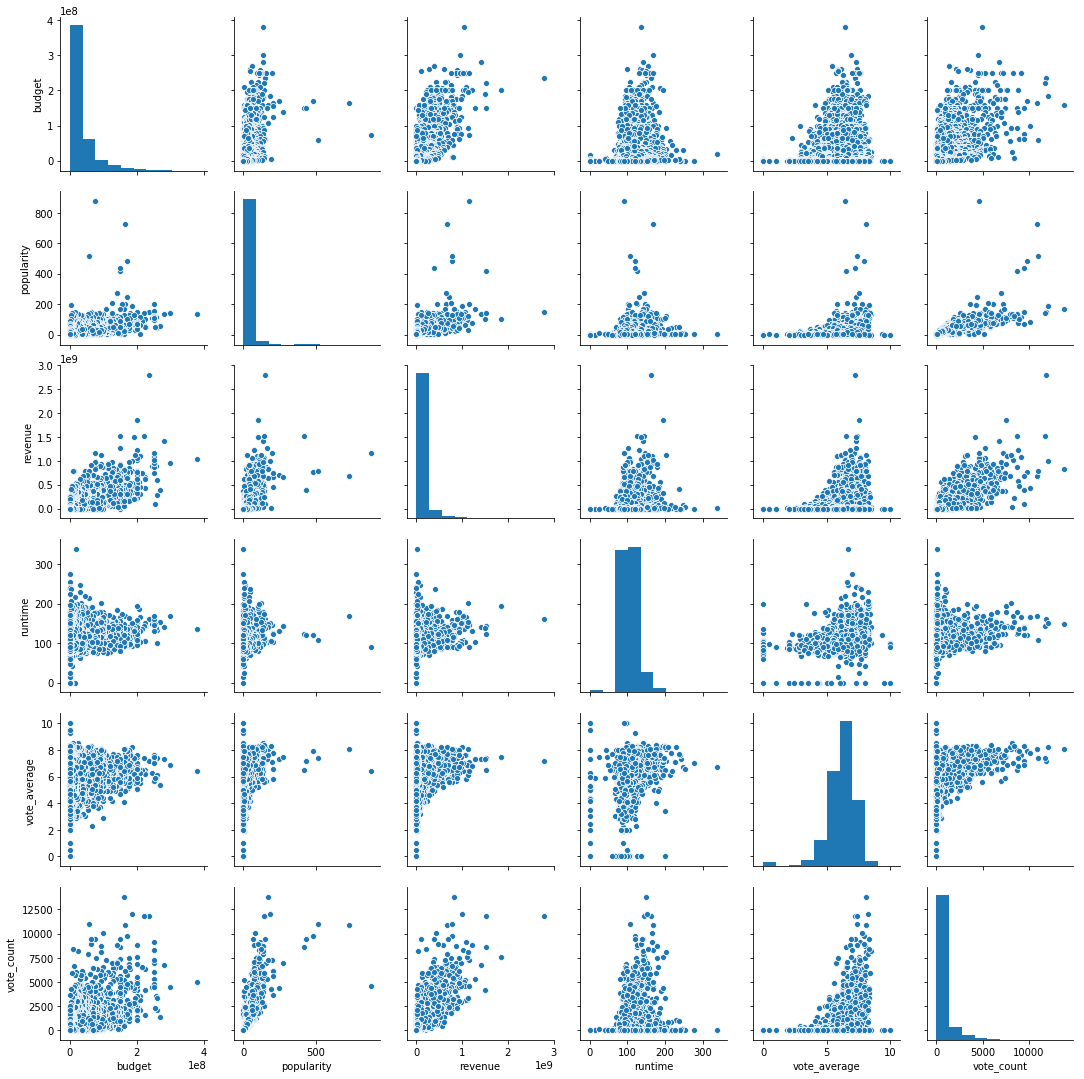

In [12]:
# !pip install seaborn --upgrade
import seaborn as sns
sns.pairplot(X)

In [35]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std_df = pd.DataFrame(X_std, columns=list(X.columns.values))
print(X_std_df.head())



from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_std_pca = pca.fit_transform(X_std )
print(X_std_pca[0:4])
X_df = pd.DataFrame(X_std_pca,columns=['1st Principal Component','2nd Principal Component'])

print(f"Dimensions reduced from:{X_std.shape} to {X_std_pca.shape}")
print(X_std_df.describe())
X_df.head(4)

   budget  popularity  revenue  runtime  vote_average  vote_count
0  5.1072      4.0532  16.6157   2.4293        0.9275      8.9997
1  6.6544      3.6963   5.3963   2.7375        0.6763      3.0862
2  5.3037      2.6996   4.9031   1.8128        0.1740      3.0587
3  5.4264      2.8548   6.1574   2.5614        1.2623      6.8174
4  5.6720      0.7052   1.2397   1.1083        0.0066      1.1615
[[17.51625467 -4.09403887]
 [ 9.58467699 -1.39684442]
 [ 7.94604987 -1.7613107 ]
 [10.99870629 -1.22368461]]
Dimensions reduced from:(4803, 6) to (4803, 2)
           budget  popularity    revenue     runtime  vote_average  vote_count
count  4.8030e+03  4.8030e+03  4803.0000  4.8030e+03    4.8030e+03  4.8030e+03
mean   0.0000e+00  0.0000e+00     0.0000  0.0000e+00    0.0000e+00  0.0000e+00
std    1.0001e+00  1.0001e+00     1.0001  1.0001e+00    1.0001e+00  1.0001e+00
min   -7.1332e-01 -6.7558e-01    -0.5052 -4.7042e+00   -5.1002e+00 -5.5913e-01
25%   -6.9392e-01 -5.2884e-01    -0.5052 -5.6501e-01 

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,1st Principal Component,2nd Principal Component
0,17.5163,-4.0940
1,9.5847,-1.3968
2,7.9460,-1.7613
3,10.9987,-1.2237


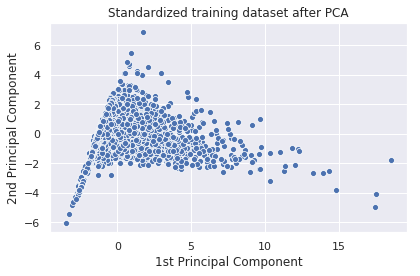

In [36]:
#!pip install seaborn --upgrade
import seaborn as sns; sns.set()
pd.set_option('chop_threshold', 0.001)
pd.set_option('precision',4)
ax = sns.scatterplot(x="1st Principal Component", y="2nd Principal Component", data=X_df)
ax.set_title('Standardized training dataset after PCA')
plt.tight_layout()
plt.show()

[[ 0.43048454  0.45951548  0.48961539  0.24890819  0.22638686  0.5005987 ]
 [-0.25417049 -0.09953298 -0.22051946  0.6115343   0.70259223 -0.09618566]]


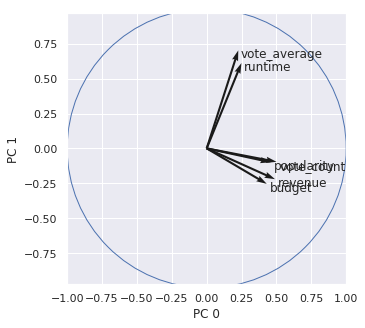

In [45]:
# Get the PCA components (loadings)
PCs = pca.components_
print(PCs[0:10])

# Use quiver to generate the basic plot
fig = plt.figure(figsize=(5,5))
plt.quiver(np.zeros(PCs.shape[1]), np.zeros(PCs.shape[1]),
           PCs[0,:], PCs[1,:], 
           angles='xy', scale_units='xy', scale=1)

# Add labels based on feature names (here just numbers)
feature_names = list(X.columns.values)
for i,j,z in zip(PCs[1,:]+0.02, PCs[0,:]+0.02, feature_names):
    plt.text(j, i, z, ha='left', va='top')

# Add unit circle
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b') # Unit Circle should be set to Max Norm (longest vector length)
plt.gca().add_artist(circle)

# Ensure correct aspect ratio and axis limits
plt.axis('equal')
plt.xlim([-1.0,1.0])
plt.ylim([-1.0,1.0])

# Label axes
plt.xlabel('PC 0')
plt.ylabel('PC 1')

# Done
plt.show()

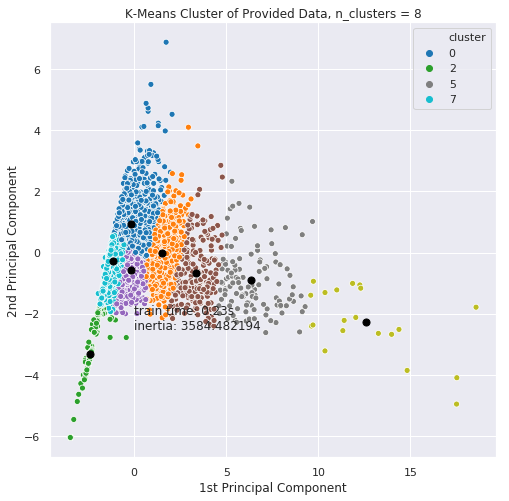

In [50]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets.samples_generator import make_blobs
sns.set(rc={'figure.figsize':(8,8)})

# Compute clustering with K-Means
X = X_df
clusters=8
k_means = KMeans(init='k-means++', n_clusters=clusters, n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0

# Generate labels and centers
labels = k_means.labels_
centers = k_means.cluster_centers_

# Join labels into X datafame
label = pd.Series(labels)
X["cluster"] = label.values

# Plot the data
g = sns.scatterplot(x="1st Principal Component", y= "2nd Principal Component", hue="cluster", data=X, palette="tab10")
g.set_title(f"K-Means Cluster of Provided Data, n_clusters = {clusters}");
#plt.scatter(X.x, X.y, c=X.cluster, s=50, cmap='tab10')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=50, alpha=1);
plt.text(0, -2.5,  'train time: %.2fs\ninertia: %f' % (t_batch, k_means.inertia_));

# Stretch Goal:

If you look at the original dataset you'll notice that I threw away some potentially useful columns. See if there are any that you could clean more effectively and turn into a numeric representation (probably some kind of one-hot-encoding of categorical variables) to assist your clustering. There's a lot more work here than the hours we have today however, so don't kill yourself trying to incorporate every single column from the original dataset, just take it one column at a time.

**Side Note** Data Science is never DONE. You just reach a point where the cost isn't worth the benefit anymore. There's always more moderate to small improvements that we could make. Don't be a perfectionist, be a pragmatist.